In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn.plotting as nil
import glob
from lito_radiomics.lito_radiomics.lito_features import shape2D
import os
import cupy as cp
from cupyx.scipy import ndimage
import math
import radiomics
from radiomics import featureextractor
from math import isclose
import SimpleITK as sitk
from scipy import spatial
import scipy
from sklearn.preprocessing import StandardScaler
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
from nibabel.affines import apply_affine
import random
import ipympl
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
def check_registration(im1, im2):
    ax, az=im1.header['qoffset_x'], im1.header['qoffset_z'] 
    bx, bz=im2.header['qoffset_x'], im2.header['qoffset_z']

    if math.isclose(az, bz, rel_tol=0.05) and math.isclose(ax, bx, rel_tol=0.05):
        return True
    else:
        return False
    

In [3]:
def rescale_to_255(array):
    """
    Rescale the values of a 2D NumPy array to the range [0, 255].
    
    Parameters:
        array (numpy.ndarray): Input 2D array.
        
    Returns:
        numpy.ndarray: Rescaled array with values in the range [0, 255].
    """
    min_val = np.min(array)
    max_val = np.max(array)

    # Ensure the array is not constant to avoid division by zero
    if min_val != max_val:
        scaled_array = 255 * (array - min_val) / (max_val - min_val)
    else:
        scaled_array = array

    return scaled_array.astype(np.uint8)

In [4]:
def fill_holes(mask):
    filled_mask = scipy.ndimage.binary_fill_holes(mask[0, :, :]).astype(float)
    return filled_mask

In [5]:
def ellipse_perimeter(a, b):
    """
    Compute the perimeter of an ellipse using Ramanujan's approximation formula.
    
    Parameters:
        a (float): Length of the semi-major axis.
        b (float): Length of the semi-minor axis.
    
    Returns:
        float: Perimeter of the ellipse.
    """
    h = ((a - b) / (a + b))**2
    perimeter = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))
    return perimeter

In [6]:
def compute_dice_ellipse(a, b, eigen_vect, mask_slice):
    
    angle1 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0])
    angle2 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0]) + np.deg2rad(90)

    center = ndimage.center_of_mass(cp.asarray(sitk.GetArrayFromImage(mask_slice)))
    xy1 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle1))
    xy2 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle2))
    ell1 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle1)
    ell2 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle2)

    contours = find_contours(sitk.GetArrayFromImage(mask_slice), 0.5)
    contours = [np.flip(contours[k]) for k in range(len(contours))]

    ellipse_estimation = EllipseModel()
    if ellipse_estimation.estimate(xy1):
        residuals1 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    if ellipse_estimation.estimate(xy2):
        residuals2 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    shape_slice = sitk.GetArrayFromImage(mask_slice).shape
    mask_ellipse1 = np.zeros(shape_slice)
    mask_ellipse1[[i for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    mask_ellipse2 = np.zeros(shape_slice)
    mask_ellipse2[[i for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    dice1=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse1.ravel())
    dice2=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse2.ravel())

    if dice1 >= dice2:
        return residuals1, dice1, xy1, mask_ellipse1, center
    else:
        return residuals2, dice2, xy2, mask_ellipse2, center

In [7]:
def standardize_roi(image, mask, desired_area):

    # Calculate the current area of the ROI
    current_area = cp.sum(mask)
    print(current_area)
    # Calculate the scaling factor
    scale_factor = cp.sqrt(desired_area / current_area)
    print(f'mask {str(mask.shape[0])} {str(mask.shape[1])} {str(scale_factor)}')
    
    return ndimage.zoom(cp.array(image), scale_factor), ndimage.zoom(cp.array(mask), scale_factor, order=0)


In [8]:
def _extracted_from_features_extraction2D_4(arg0, cut, data_spacing):
    result = sitk.GetImageFromArray(arg0[int(cut), :, :])
    result.SetSpacing(
        (
            float(data_spacing[0]),
            float(data_spacing[1]),
            float(data_spacing[2]),
        )
    )
    result = sitk.JoinSeries(result)

    return result

In [9]:
# TODO Rename this here and in `features_extraction2D`
def _extracted_from_features_extraction2D_11():
    result = featureextractor.RadiomicsFeatureExtractor(force2D=True)
    result.disableAllFeatures()
    result.enableFeaturesByName(
        shape2D=[
            "PerimeterSurfaceRatio",
            "Sphericity",
            "MajorAxisLength",
            "MinorAxisLength",
            "Perimeter",
        ]
    )

    return result

In [10]:
def for_ellipse_creation(features_extractor, image, mask):
    results = features_extractor.execute(image, mask)
    features_lito = shape2D.LitoRadiomicsShape2D(image, mask)
    features_eigenvect = features_lito.getEigenVectorsFeatureValue()
    
    a = float(results['original_shape2D_MajorAxisLength'])/2  # Semi-major axis
    b = float(results['original_shape2D_MinorAxisLength'])/2  # Semi-minor axis
    perimeter = ellipse_perimeter(a, b)
    real_perimeter = float(results['original_shape2D_Perimeter'])
    ellipticity = perimeter/real_perimeter
    
    return results, features_eigenvect, a, b, ellipticity

In [11]:
def features_extraction2D(a_im, a_ma, cut, filled=True):

    data_spacing = [1,1,1]
    sitk_img = _extracted_from_features_extraction2D_4(a_im, cut, data_spacing)
    sitk_mask = _extracted_from_features_extraction2D_4(a_ma, cut, data_spacing)
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

    if filled is True:
        sitk_mask = sitk.GetImageFromArray(fill_holes(sitk.GetArrayFromImage(sitk_mask)))
    resized_image, resized_mask = standardize_roi(sitk.GetArrayFromImage(sitk_img), sitk.GetArrayFromImage(sitk_mask), 1250)
    resized_image = sitk.GetImageFromArray(cp.asnumpy(resized_image))
    resized_mask = sitk.GetImageFromArray(cp.asnumpy(resized_mask))
    features_40_slice = _extracted_from_features_extraction2D_11()
    features_40_slice_resized = _extracted_from_features_extraction2D_11()
    #try:
    image = sitk_img[:, :, 0] if filled is True else sitk_img
    resized_image = resized_image[:, :, 0] if filled is True else resized_image
    results, features_eigenvect, a, b, ellipticity = for_ellipse_creation(features_40_slice, image, sitk_mask)
    results_resized, features_eigenvect_resized, a_resized, b_resized, _ = for_ellipse_creation(features_40_slice_resized, resized_image, resized_mask)

    res, di, cont_ellipse, mask_ell, center = compute_dice_ellipse(a, b, features_eigenvect, sitk_mask)
    _, di_resized, _, _, _ = compute_dice_ellipse(a_resized, b_resized, features_eigenvect_resized, resized_mask)
    
    return ellipticity, float(results['original_shape2D_PerimeterSurfaceRatio']), float(results['original_shape2D_Sphericity']), res, di, di_resized, cont_ellipse, mask_ell, center

    # except ValueError:
    #     return None, None, None, None, None, None, None, None, None




In [12]:
def check_orientation(ct_image, ct_arr):
    """
    Check the NIfTI orientation, and flip to  'RPS' if needed.
    :param ct_image: NIfTI file
    :param ct_arr: array file
    :return: array after flipping
    """
    x, y, z = nib.aff2axcodes(ct_image.affine)
    
    if x != 'R':
        ct_arr = np.rot90(ct_arr, axes=(0,2), k=1)
    if y != 'P':
        ct_arr = np.flip(ct_arr, axis=1)
    if z != 'S':
        ct_arr = np.flip(ct_arr, axis=2)
    
    return ct_arr

In [13]:
def remove_out_of_box_mask(mask, box):
    _, y, z = np.where(~box.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max()
    
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)


    mask[:, :y_min_iso, :] = mask[:, y_max_iso+1:, :] = mask[:, :, :z_min_iso] = mask[:, :, z_max_iso+1:] = 0
    
    return mask
    

In [14]:
def add_random_rotation(im, gamma, alpha, beta):

    cos_gamma = np.cos(gamma)
    sin_gamma = np.sin(gamma)

    
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)

    
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    
    rotation_affine_gamma = np.array([[cos_gamma, -sin_gamma, 0, 0],
                                      [sin_gamma, cos_gamma, 0, 0],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    
    rotation_affine_alpha = np.array([[cos_alpha, 0, sin_alpha, 0],
                                      [0, 1, 0, 0],
                                      [-sin_alpha, 0, cos_alpha, 0],
                                      [0, 0, 0, 1]])
    rotation_affine_beta = np.array([[1, 0, 0, 0],
                                     [0, cos_beta, -sin_beta, 0],
                                     [0, sin_beta, cos_beta, 0],
                                     [0, 0, 0, 1]])
    
    rotated_data_ax = ndimage.rotate(cp.array(im.dataobj), np.rad2deg(gamma), axes=(1, 2), reshape=True)#False)
    rotated_data_ax_cor = ndimage.rotate(rotated_data_ax, np.rad2deg(alpha), axes=(0, 2), reshape=True)#False)
    rotated_data_ax_cor_sag = ndimage.rotate(rotated_data_ax_cor, np.rad2deg(beta), axes=(0, 1), reshape=True)#False)
    im_affine_ax = im.affine.dot(rotation_affine_gamma)
    im_affine_ax_sag = im_affine_ax.dot(rotation_affine_alpha)
    im_affine_ax_sag_cor = im_affine_ax_sag.dot(rotation_affine_beta)

    return rotated_data_ax_cor_sag, im_affine_ax_sag_cor

In [15]:
def resegment_thresholding(image, mask, thresh=0.2):
    
    max = (image*mask).max()
    print(thresh*max)
    new_mask20= np.ma.masked_where((image*mask) > thresh*max, mask)

    return new_mask20.mask.astype(float)

In [16]:
def random_slice_selection(rotated_image, rotated_mask, rotated_bb, biggest_cut_size):
    
    min_mask = np.argwhere(rotated_mask==1)[:, 0].min()
    max_mask = np.argwhere(rotated_mask==1)[:, 0].max()
    x = random.randint(min_mask, max_mask+1)
    x=353
    print(x)
    slice_ma_for_db = rotated_mask[x, :, :]

    if np.count_nonzero(slice_ma_for_db) > 0.05*biggest_cut_size:
        print('here')
        ellipticity, peri_surf_ratio, sphericity, residuals, dice, dice_resized, cont_ellipse, mask_ell, center = features_extraction2D(rotated_image, rotated_mask, x)
    else:
        ellipticity, peri_surf_ratio, sphericity, residuals, dice, dice_resized, cont_ellipse, mask_ell, center = None, None, None, None, None, None, None, None, None
        
    return x, ellipticity, dice, dice_resized, cont_ellipse, center

In [17]:
def create_n_instances(a_im, a_ma, a_ma_bb):
    gamma = random.uniform(np.deg2rad(0), np.deg2rad(360))
    alpha = random.uniform(np.deg2rad(0), np.deg2rad(360))
    beta = random.uniform(np.deg2rad(0), np.deg2rad(360))
    
    gamma = 3.098940156913352 
    alpha = 5.015570092189746
    beta = 3.6688239607670976

    print(f'gamma: {str(np.rad2deg(gamma))}')
    print(f'alpha: {str(np.rad2deg(alpha))}')
    print(f'beta: {str(np.rad2deg(beta))}')

    a_im_rotated, rotated_affine = add_random_rotation(a_im, gamma, alpha, beta)
    a_ma_rotated, ma_rotated_affine = add_random_rotation(a_ma, gamma, alpha, beta)
    a_ma_bb_rotated, ma_bb_rotated_affine = add_random_rotation(a_ma_bb, gamma, alpha, beta)
    a_ma_rotated[a_ma_rotated > 0.1] = 1
    a_ma_rotated[a_ma_rotated <=0.1] = 0
    a_ma_bb_rotated[a_ma_bb_rotated > 0.1] = 1
    a_ma_bb_rotated[a_ma_bb_rotated <=0.1] = 0
    new_image = nib.Nifti1Image(a_im_rotated, affine=rotated_affine)

    original_new_mask = nib.Nifti1Image(ndimage.binary_fill_holes(a_ma_rotated).astype(np.uint8), affine=ma_rotated_affine)
    #new_mask = nib.Nifti1Image(resegment_thresholding(np.array(a_im_rotated.get()), np.array(a_ma_rotated.get())), affine=ma_rotated_affine)
    new_mask_bb = nib.Nifti1Image(a_ma_bb_rotated, affine=ma_bb_rotated_affine)

    final_rot_image = cp.float32(new_image.dataobj.get())
    final_rot_mask = cp.float32(original_new_mask.dataobj.get())
    final_rot_mask_orig = cp.float32(original_new_mask.dataobj.get())
    final_rot_mask_bb = cp.float32(new_mask_bb.dataobj.get())
    final_rot_mask = remove_out_of_box_mask(final_rot_mask, np.ma.masked_equal(final_rot_mask_bb, 0))

    inside_bb_rotated = final_rot_mask_bb * final_rot_image
    to_display_rotated = np.ma.masked_equal(inside_bb_rotated, 0)
    biggest_cut = np.max([np.count_nonzero(final_rot_mask[k, :, :]) for k in range(final_rot_mask.shape[0])])

    slice_nb, ellipticity, dice, dice_resized, cont_ellipse, cent = random_slice_selection(final_rot_image, final_rot_mask, final_rot_mask_bb, biggest_cut)

    return final_rot_image, final_rot_mask, final_rot_mask_orig, final_rot_mask_bb, slice_nb, ellipticity, dice, dice_resized, cont_ellipse, cent

In [18]:
def plot_1slice(im, ma, bb, center_ell, slice_nb, ell, dice, dice_resized):
    
    plt.close('all')
    inside_bb = bb * im
    to_display = np.ma.masked_equal(inside_bb, 0)

    x, y, z = np.where(~to_display.mask)

    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max() 

    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)

    y_mask, x_mask = np.where(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]==1)
    x_min_mask = x_mask.min()
    x_max_mask = x_mask.max()
    y_min_mask = y_mask.min()
    y_max_mask = y_mask.max()
    
    center = ndimage.center_of_mass(cp.asarray(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]))
    translated_ell = ell - (np.array([center_ell[1].item(), center_ell[0].item()]) - np.array([center[1].item(), center[0].item()]))
    center_ma = [x_min_mask + (x_max_mask-x_min_mask)/2, y_min_mask + (y_max_mask-y_min_mask)/2]
    plt.imshow(im[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], interpolation='none', cmap='grey')
    plt.imshow(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], alpha=0.25*(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]>0))
    plt.plot(translated_ell[:, 0], translated_ell[:, 1])
    #plt.scatter(center[1].get(), center[0].get())
    #plt.scatter(center_ma[0], center_ma[1])
    plt.title(f'{str(dice)[:5]}')# {str(dice_resized)[:5]}')

    plt.show()
    

In [19]:
def plot_slices(slices_im, slices_ma, slices_bb, center_ells, slices_nbs, ells, dices, dices_resized, n, mins, maxs):

    n_columns = 8
    n_rows = n // n_columns

    if n % n_columns != 0:
        n_rows += 1
    plt.close('all')
    _, axs = plt.subplots(n_rows, n_columns, sharex=True, sharey=True, figsize=(10, 5))
    axs = axs.flatten()
    for i in range(n):
        inside_bb = slices_bb[i] * slices_im[i]
        to_display = np.ma.masked_equal(inside_bb, 0)

        x, y, z = np.where(~to_display.mask)
        y_min = y.min()
        y_max = y.max()
        z_min = z.min()
        z_max = z.max() 

        y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
        y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
        z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
        z_max_iso = int(z_max - (z_max-z_min)/2 + 25)
        
        y_mask, x_mask = np.where(slices_ma[i][slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]==1)
        x_min_mask = x_mask.min()
        x_max_mask = x_mask.max()
        y_min_mask = y_mask.min()
        y_max_mask = y_mask.max()
        
        #center_ma = [x_min_mask + (x_max_mask-x_min_mask)/2, y_min_mask + (y_max_mask-y_min_mask)/2]
        center = ndimage.center_of_mass(cp.asarray(slices_ma[i][slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]))
        translated_ell = ells[i] - (np.array([center_ells[i][1].item(), center_ells[i][0].item()]) - np.array([center[1].item(), center[0].item()]))
        
        axs[i].imshow(slices_im[i][slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], interpolation='none', cmap='grey', vmin=mins[i], vmax=maxs[i])
        axs[i].imshow(slices_ma[i][slices_nbs[i],y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], alpha=0.25*(slices_ma[i][slices_nbs[i],y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]>0))
        axs[i].plot(translated_ell[:, 0], translated_ell[:, 1])
        axs[i].scatter(center[1].get(), center[0].get())
        #axs[i].scatter(center_ma[0], center_ma[1])
        axs[i].title.set_text(f'{str(dices[i])[:5]} {str(dices_resized[i])[:5]}')

    for ax in axs:
        if not bool(ax.get_images()):
            ax.remove()
    
    _.tight_layout()
    plt.show()


In [20]:
path_data = "/mnt/data/psteinmetz/neotex/to_process/Ozgun/184"
image_path_sub = glob.glob(
    f'{path_data}/RawVolume/*subtracted*_Bspline_zscore.nii.gz'
)

mask_bb_path = glob.glob(f'{path_data}/RoiVolume/VOI_bb.nii.gz')
mask_path = glob.glob(f'{path_data}/RoiVolume/VOI_morphoclosing.nii.gz')

image = nib.load(image_path_sub[0])
mask_bb = nib.load(mask_bb_path[0])
mask = nib.load(mask_path[0])

In [21]:
a_im_rescaled = nib.Nifti1Image(rescale_to_255(check_orientation(image, np.array(image.dataobj))), affine=image.affine)
a_im = nib.Nifti1Image(check_orientation(image, np.array(image.dataobj)), affine=image.affine)
a_ma = check_orientation(mask, np.array(mask.dataobj))
a_ma[a_ma > 0.1] = 1
a_ma[a_ma <=0.1] = 0
a_ma = nib.Nifti1Image(a_ma, affine=mask.affine)
a_ma_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
a_ma_bb = nib.Nifti1Image(np.ma.masked_where(a_ma_bb>0.1, a_ma_bb), affine=mask_bb.affine)


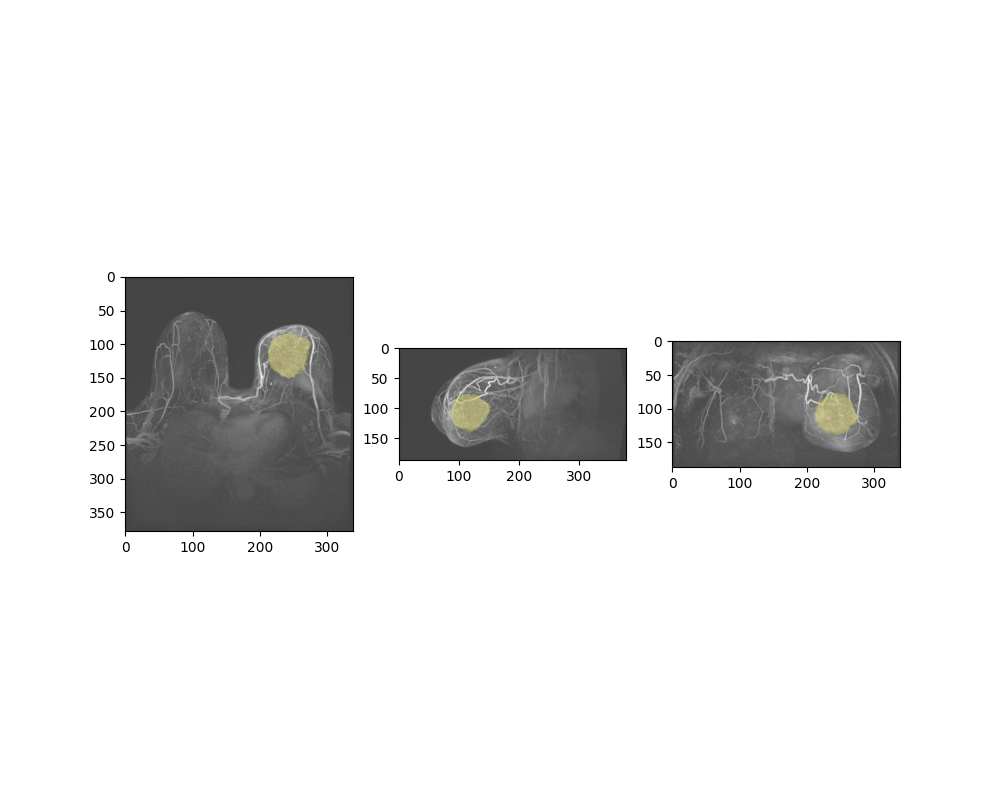

In [22]:
mip_ax=  np.max(np.array(a_im_rescaled.dataobj), axis=0)
mip_cor= np.max(np.array(a_im_rescaled.dataobj), axis=1)
mip_sag= np.max(np.array(a_im_rescaled.dataobj), axis=2)

mip_ax_bb=  np.max(np.array(a_ma_bb.dataobj), axis=0)
mip_cor_bb= np.max(np.array(a_ma_bb.dataobj), axis=1)
mip_sag_bb= np.max(np.array(a_ma_bb.dataobj), axis=2)

mip_ax_mask=  np.max(np.array(a_ma.dataobj), axis=0)
mip_cor_mask= np.max(np.array(a_ma.dataobj), axis=1)
mip_sag_mask= np.max(np.array(a_ma.dataobj), axis=2)

plt.close('all')


_, axs = plt.subplots(1, 3, figsize=(10, 8))
for img, ma, ax in zip([mip_ax, mip_sag, mip_cor], [mip_ax_mask, mip_sag_mask, mip_cor_mask], axs):
    ax.imshow(img, cmap='grey', vmin=np.min(np.array(a_im_rescaled.dataobj)), vmax=np.max(np.array(a_im_rescaled.dataobj)))
    ax.imshow(ma, alpha=0.25*(ma>0))
plt.show()

In [23]:
final_rot_image, final_rot_mask, final_rot_mask_orig, final_rot_mask_bb, slice_nb, ellipticity, dice, dice_resized, cont_ellipse, center = create_n_instances(a_im, a_ma, a_ma_bb)

gamma: 177.55619195474415
alpha: 287.3709981345137
beta: 210.208128728425
353
here
2322.0
mask 538 284 0.7337090886046865


In [24]:
dice_resized

0.9464073044859072

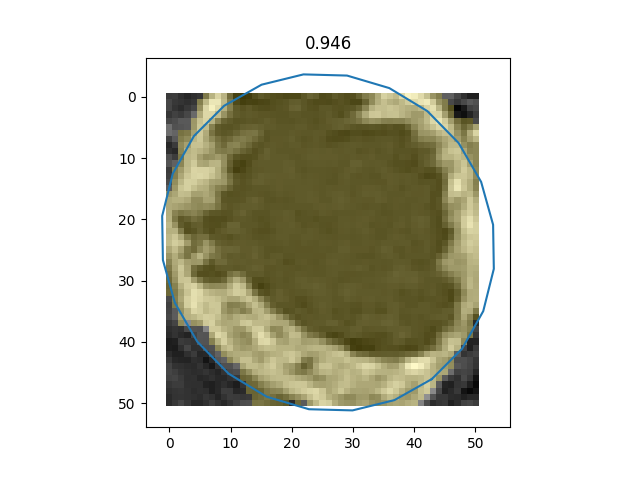

In [25]:
plot_1slice(final_rot_image, final_rot_mask, final_rot_mask_bb, center, slice_nb, cont_ellipse, dice, dice_resized)

In [48]:
slices_im = []
slices_ma = []
slices_bb = []
slices_nbs = []
centers = []
cont_ellipses = []
dices = []
dices_resized = []
mins=[]
maxs=[]

for _ in range(50):
    final_rot_image, final_rot_mask, final_rot_mask_orig, final_rot_mask_bb, slice_nb, ellipticity, dice, dice_resized, cont_ellipse, center = create_n_instances(a_im, a_ma, a_ma_bb)
    vmin=np.min(final_rot_image)
    vmax=np.max(final_rot_image)
    if cont_ellipse is None:
        print('wrong slice')
    else:
        slices_im.append(final_rot_image)
        slices_ma.append(final_rot_mask)
        slices_bb.append(final_rot_mask_bb)
        slices_nbs.append(slice_nb)
        cont_ellipses.append(cont_ellipse)
        dices.append(dice)
        dices_resized.append(dice_resized)
        mins.append(vmin)
        maxs.append(vmax)
        centers.append(center)

gamma: 111.66856702023058
alpha: 334.6201884018283
beta: 310.96250694277074
435
here
365.0
mask 664 574 1.8505830254940132
gamma: 288.9492703759631
alpha: 130.83973460826812
beta: 13.09467774642715
306
here
318.0
mask 638 493 1.9826289642953603
gamma: 92.53265532194735
alpha: 35.33371229674145
beta: 44.32820997646753
280
here
301.0
mask 598 468 2.037847864848056
gamma: 191.53677355515035
alpha: 306.6605886840544
beta: 175.49585017154385
169
here
88.0
mask 533 449 3.768891807222045
gamma: 47.8268072529772
alpha: 293.39925880804907
beta: 138.3652501515631
428
here
614.0
mask 854 411 1.4268253638383739
gamma: 281.5493192514224
alpha: 144.61332300517475
beta: 303.06951172657017
252
here
46.0
mask 641 514 5.212860351426869
gamma: 182.43239063062381
alpha: 212.2404241795849
beta: 181.52372262899624
198
here
119.0
mask 446 471 3.241018617760822
gamma: 136.37487305947673
alpha: 142.13620698109187
beta: 334.51753014185743
324
here
484.0
mask 756 585 1.6070608663330626
gamma: 323.97461268778466


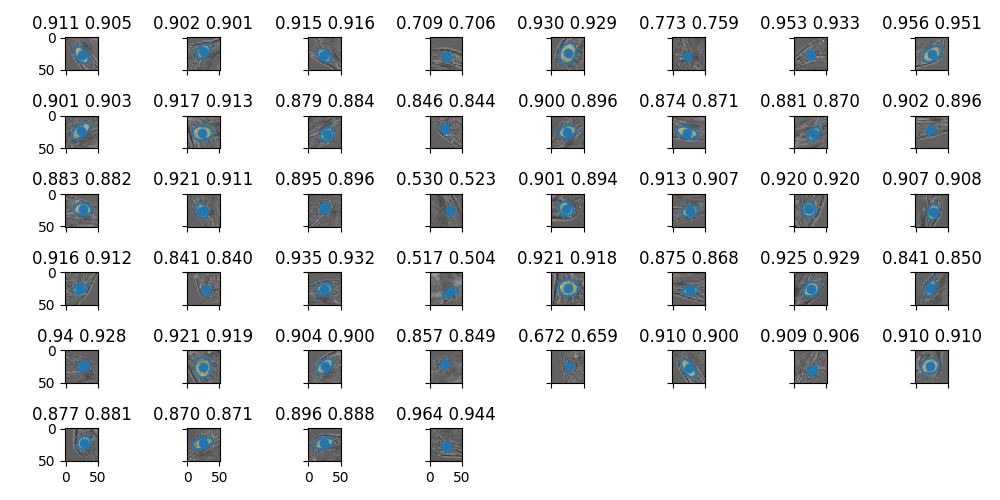

In [49]:
plot_slices(slices_im, slices_ma, slices_bb, centers, slices_nbs, cont_ellipses, dices, dices_resized, len(slices_im), mins, maxs)